# Results

### Load required packages

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(data.table))
suppressMessages(library(tidymodels))
suppressMessages(library(pROC))

### Load Data

In [2]:
setwd("/home/jacky/Project/DiseaseGenePipieline/MachineLearning_Ver6/00_Data")
load("MachineLearning_Input.rda")

In [12]:
setwd("/home/jacky/Project/DiseaseGenePipieline/ComparingOtherCelltype_20241205/Data")
snp_scoring_input <- fread("SnpPrioritization_Input.txt")
snp_scoring_input <- as.data.frame(snp_scoring_input[, -c("CHR", "BP")]) %>% 
                        drop_na() %>% distinct(SNP, .keep_all = TRUE)

In [13]:
table(duplicated(colnames(machine_learning_input)))
table(duplicated(snp_scoring_input$SNP))


 FALSE 
891923 


 FALSE 
161085 

In [14]:
colnames(snp_scoring_input)

[1] "SNP"                        "P"                         
 [3] "H3K27ac"                    "H3K27me3"                  
 [5] "H3K4me1"                    "H3K4me2"                   
 [7] "H3K4me3"                    "H3K36me3"                  
 [9] "epiblast_20241205"          "non_neuroectoderm_20241205"
[11] "epidermal_20241205"         "placode_20241205"          
[13] "neural_crest_20241205"      "neuroectoderm_20241205"    
[15] "telencephalon_20241205"     "diencephalon_20241205"     
[17] "mesencephalon_20241205"     "rhombomere_20241205"       
[19] "roof_plate_20241205"

### Define functions

In [6]:
main2 <- function(main_snp_score_table, main_ml_table) {
    foom_selected_snp <- top.snp2(main_snp_score_table, main_ml_table)
    foom_selected_matrix <- main_ml_table[, c("default", foom_selected_snp)]
    return(list.roc2(foom_selected_matrix))
    }


main2.onlyp <- function(foo1_p_matrix, main_ml_table) {
    foo1_p_matrix$P <- scale.pseudocount(-log10(foo1_p_matrix$P))
    snp_score <- foo1_p_matrix %>% select(SNP, P)
    # select top snps
    foo_snp_score_intersected <- snp_score[snp_score$SNP %chin% colnames(main_ml_table[,-1]),]
    foo1_selected_snp <- head(foo_snp_score_intersected[order(foo_snp_score_intersected$P, decreasing = TRUE),], n = (nrow(main_ml_table)%/%5)) %>% pull(SNP)
    foom_selected_matrix <- main_ml_table[, c("default", foo1_selected_snp)]
    return(list.roc2(foom_selected_matrix))
    }



#scale between 0 and 100, add pseudocount
scale.pseudocount <- function(x) {   
    ((x - min(x))/(max(x) - min(x)))*100 + 1
    }


top.snp2 <- function(foo1_p_matrix, main_ml_table) {
    foo1_p_matrix$P <- scale.pseudocount(-log10(foo1_p_matrix$P))
    
    for(i in 3:ncol(foo1_p_matrix)) {
        foo1_p_matrix[,i] <- scale.pseudocount(foo1_p_matrix[,i])
    }

    foo1_p_matrix$Score <- apply(foo1_p_matrix[,2:ncol(foo1_p_matrix)], 1, prod)
    snp_score <- foo1_p_matrix %>% select(SNP, Score)

    # select top snps
    foo_snp_score_intersected <- snp_score[snp_score$SNP %chin% colnames(main_ml_table[,-1]),]
    foo1_selected_snp <- head(foo_snp_score_intersected[order(foo_snp_score_intersected$Score, decreasing = TRUE),], n = (nrow(machine_learning_input)%/%5)) %>% pull(SNP)
    return(foo1_selected_snp)
    }



# mean roc curve of 200 iteration
list.roc2 <- function(foo_matrix2) {

    foo_lr_df <- data.frame(.pred_Yes = double(), default = factor(), replication = integer(), stringsAsFactors = FALSE)
    auc_list <- list()
    
    for (i in c(1:200)) {
        foo_split <- initial_split(foo_matrix2, prop = 0.7, strata = default)
        foo_train <- foo_split %>% training()
        foo_test <- foo_split %>% testing()
        
        foo_lr_fit <- logistic_reg(mixture = double(1), penalty = double(1)) %>% 
            set_engine("glmnet") %>% set_mode("classification") %>% 
            fit(default ~ ., data = foo_train)
        
        foo_lr_prediction <- as.data.frame(predict(foo_lr_fit, new_data = foo_test, type = "prob"))
        foo_lr_prediction$default <- foo_test$default
        foo_lr_prediction <- foo_lr_prediction %>% select(-".pred_No")

        auc_list <- c(auc_list, auc(roc(response = foo_lr_prediction$default, predictor = foo_lr_prediction$.pred_Yes, direction = "<", levels = c("No", "Yes"))))
        
        foo_lr_prediction$replication <- i
        foo_lr_df <- rbind(foo_lr_df, foo_lr_prediction)    
    }

    # foo_mean_roc <- roc(response = foo_lr_df$default, predictor = foo_lr_df$.pred_Yes, direction = "<", levels = c("No", "Yes"))
    # ci_roc_mean <- ci.se(foo_mean_roc, specificities=seq(0, 1, l=100))
    # dat.ci <- data.frame(x = as.numeric(rownames(ci_roc_mean)),
    #                      lower = ci_roc_mean[, 1],
    #                      upper = ci_roc_mean[, 3])
    
    # P <- ggroc(foo_mean_roc) + theme_classic() + geom_abline(slope=1, intercept = 1, linetype = "dashed", alpha=0.7, color = "grey", linewidth = 0.5) + coord_equal() + 
    #   geom_ribbon(data = dat.ci, aes(x = x, ymin = lower, ymax = upper), fill = "#faa307", alpha= 0.2)

    # plot(P)
    # cat("Mean AUROC:", mean(as.numeric(auc_list)), "\n", "AUROC of Plot:", auc(foo_mean_roc))

    return(as.numeric(auc_list))
    }

In [8]:
setwd("/home/datastore2/jackyyam/projects/craniofaical-genomics/classifier_best-vs-baseline")

In [9]:
auc_data <- fread(file = "outputs/auc_base-vs-best.txt")
auc_data

auc,group
<dbl>,<chr>
0.9188581,base
0.9062500,base
0.9042986,base
0.8890073,base
0.8944251,base
0.9177566,base
0.9160000,base
0.8960166,base
0.9372459,base


In [32]:
### base
# roc_list_base_400kb <- main2.onlyp(snp_scoring_input[,c("SNP","P")], machine_learning_input)

In [76]:
### best
# roc_list_best_400kb <- main2(snp_scoring_input[,c("SNP","P","H3K27me3","H3K4me3","H3K36me3","placode_400kb","neural_crest_400kb")], machine_learning_input)

In [19]:
### worst
roc_list_worst_400kb <- main2(snp_scoring_input[,c("SNP","P","H3K27ac","H3K27me3","H3K4me1","non_neuroectoderm_20241205","placode_20241205")], machine_learning_input)

In [20]:
mean(roc_list_worst_400kb)

[1] 0.8155252

In [21]:
worst_df <- as.data.frame(roc_list_worst_400kb)

In [22]:
colnames(worst_df) <- "auc"

In [23]:
worst_df$group <- "worst"

In [25]:
worst_df

auc,group
<dbl>,<chr>
0.7959559,worst
0.7753846,worst
0.7887228,worst
0.8357111,worst
0.8347826,worst
0.8525619,worst
0.7810202,worst
0.8698782,worst
0.8155134,worst


In [26]:
auc_data <- rbind(auc_data[,c("auc", "group")], worst_df[,c("auc", "group")])
auc_data

auc,group
<dbl>,<chr>
0.9188581,base
0.9062500,base
0.9042986,base
0.8890073,base
0.8944251,base
0.9177566,base
0.9160000,base
0.8960166,base
0.9372459,base


In [36]:
auc_data$group_num <- c(rep("02_base", 200), rep("01_best", 200), rep("03_worst", 200))

In [87]:
t.test(base_df$auc, best_df$auc)


	Welch Two Sample t-test

data:  base_df$auc and best_df$auc
t = -26.512, df = 370.67, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.04437712 -0.03824872
sample estimates:
mean of x mean of y 
0.9074771 0.9487900 


In [32]:
t.test(auc_data[auc_data$group == "base",]$auc, worst_df$auc)


	Welch Two Sample t-test

data:  auc_data[auc_data$group == "base", ]$auc and worst_df$auc
t = 43.971, df = 366.35, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.08783964 0.09606415
sample estimates:
mean of x mean of y 
0.9074771 0.8155252 


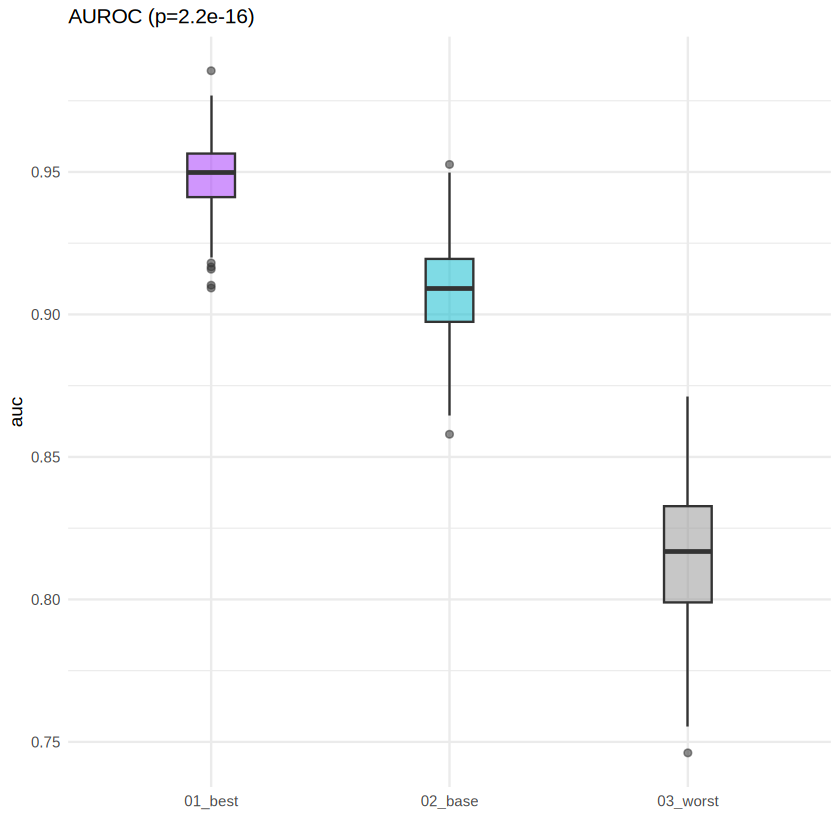

In [40]:
p <- auc_data %>%
  ggplot( aes(x=group_num, y=auc, fill=group, alpha = 0.9)) +
  geom_boxplot(width = 0.2) +
  scale_fill_manual(values = c("#17BECF","#AA40FC", "grey60")) +
  # geom_jitter(color="grey30", width = 0.2, size=0.5, alpha=0.7) +
  theme_minimal() +
  theme(
    legend.position="none",
    plot.title = element_text(size=12)
  ) +
  ggtitle("AUROC (p=2.2e-16)") +
  xlab("") 

p

In [48]:
ggsave(p, file = "plots/boxplot_auc_base-vs-best-vs-worst.svg", width = 3, height = 4, dpi = 300)